In [15]:
from PIL import Image
import shutil
import pandas as pd
from IPython.display import Image, HTML
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from colorthief import ColorThief
import re
import numpy as np
from slugify import slugify

### Define Functions

In [2]:
def str_formatter(x):
    x = re.sub('\t', '', x)
    x = re.sub('\n', '', x)
    return x

In [3]:
#Web scraping web archives (odd rows)
def archive_odd(index):
    global album, album_cover, img_url, album_artist, album_name, file_name
    album = soup.find_all('table', class_ = 'cbbTable_rowOn')[index]
        #Returns the gray rows in the table, odd rows
    album_cover = album.find_all(class_='cbbTable_c2')[0].find_all('img')[0].attrs['src']
        #Returns image link
    img_url = url_prefix + album_cover
        #Returns full image link
    album_artist = album.find_all('div', class_='cbbTable_text3')[0].text
        #Returns artist name
    album_artist = str_formatter(album_artist)
        #Returns artist name without formatting
    album_name = album.find_all('div', class_='cbbTable_text4')[0].text
        #Returns album name
    album_name = str_formatter(album_name)
        #Returns album name without formatting
    file_name = slugify(album_name)
        #Formats album names to usable file names
    save_image(img_url)
    colorthief(file_name)
    df_append(y)

In [4]:
#Web scraping web archives (even rows)
def archive_even(index):
    global album, album_cover, img_url, album_artist, album_name, file_name
    album = soup.find_all('table', class_ = 'cbbTable_rowOff')[index]
        #Returns the white rows in the table, even rows
    album_cover = album.find_all(class_='cbbTable_c2')[0].find_all('img')[0].attrs['src']
        #Returns image link
    img_url = url_prefix + album_cover
        #Returns full image link
    album_artist = str_formatter(album.find_all('div', class_='cbbTable_text3')[0].text)
        #Returns artist name
    album_name = str_formatter(album.find_all('div', class_='cbbTable_text4')[0].text)
        #Returns album name
    file_name = slugify(album_name)
        #Formats album names to usable file names
    save_image(img_url)
    colorthief(file_name)
    df_append(y)

In [5]:
#Web scraping current Billboards

def billboards(index):
    global album, album_cover, img_url, album_artist, album_name, file_name
    album = soup.find_all('div', class_ = 'o-chart-results-list-row-container')[index]
        #Returns each row
    img_url = album.find_all('li', class_ = 'o-chart-results-list__item')[1].find('img').attrs['data-lazy-src']
        #Returns image link
    album_artist = str_formatter(album.find_all('span')[1].text)
        #Returns artist name
    album_name = str_formatter(album.find('h3').text)
        #Returns album name
    file_name = slugify(album_name)
        #Formats album names to usable file names
    save_image(img_url)
    colorthief(file_name)
    df_append(y)

In [6]:
#Saves images
def save_image(img_url):
    r = requests.get(img_url, stream=True) #Get request on full_url
    if r.status_code == 200:                     #200 status code = OK
       with open(f"album covers/{file_name}.jpg", 'wb') as f: 
          r.raw.decode_content = True
          shutil.copyfileobj(r.raw, f)

In [7]:
#Convert rgb to hexcode
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

#Dominant color
def colorthief(album_name):
    global album_color
    color_thief = ColorThief(f'album covers/{album_name}.jpg')
    dominant_color = color_thief.get_color(quality=1)
    album_color = rgb_to_hex(dominant_color)

In [8]:
#Append to dataframe
def df_append(y):
    global df_albums
    df_row = [album_name, album_artist, year, y, f'<img src="album covers/{file_name}.jpg"/>', album_color]
    df = pd.DataFrame(df_row).transpose()
    df.columns = ['Album', 'Artist', 'Release Year', 'Rank', 'Cover', 'Color']
    df_albums = pd.concat([df_albums.loc[:], df]).reset_index(drop=True)

### Generates Dataframe of Top 5 Selling Albums 1990 - 2022

In [12]:
user_agent = {'User-agent': 'Mozilla/5.0'}
df_albums = pd.DataFrame(columns = ['Album', 'Artist', 'Release Year', 'Rank', 'Cover', 'Color'])

for year in range(1990, 2023):
    if year < 2002:
        url = f"https://web.archive.org/web/20071222015019/http://www.billboard.com/bbcom/charts/yearend_chart_display.jsp?f=The+Billboard+200&g=Year-end+Albums&year={year}"
        r = requests.get(url, headers = user_agent)
        soup = BeautifulSoup(r.text,"html.parser")
        url_prefix = 'https://web.archive.org'

        try:
            for y in np.array([1,2,3,4,5]):
                if y in np.array([1,3,5]):
                    index = int(y/2)
                    archive_odd(index)
                else:
                    index = int(y/2-1)
                    archive_even(index)
        except:
            pass
    else:
        url = f"https://www.billboard.com/charts/year-end/{year}/top-billboard-200-albums/"

        r = requests.get(url, headers = user_agent)
        soup = BeautifulSoup(r.text,"html.parser")

        for y in np.array([1,2,3,4,5]):
            index = int(y-1)
            billboards(index)

In [10]:
album_name

'Pieces Of You'

In [14]:
HTML(df_albums.to_html(escape=False))

,Album,Artist,Release Year,Rank,Cover,Color
0,Janet Jackson's Rhythm Nation 1814,Janet Jackson,1990,1,,#282628
1,...But Seriously,Phil Collins,1990,2,,#d6b37b
2,Soul Provider,Michael Bolton,1990,3,,#e0c8ae
3,Pump,Aerosmith,1990,4,,#e2dde1
4,Please Hammer Don't Hurt 'Em,M.C. Hammer,1990,5,,#d2b9bc
5,Mariah Carey,Mariah Carey,1991,1,,#362928
6,No Fences,Garth Brooks,1991,2,,#2e3231
7,Shake Your Money Maker,The Black Crowes,1991,3,,#28231e
8,Gonna Make You Sweat,C&C Music Factory,1991,4,,#eaece9
9,Wilson Phillips,Wilson Phillips,1991,5,,#947677


https://stackoverflow.com/questions/3241929/python-find-dominant-most-common-color-in-an-image

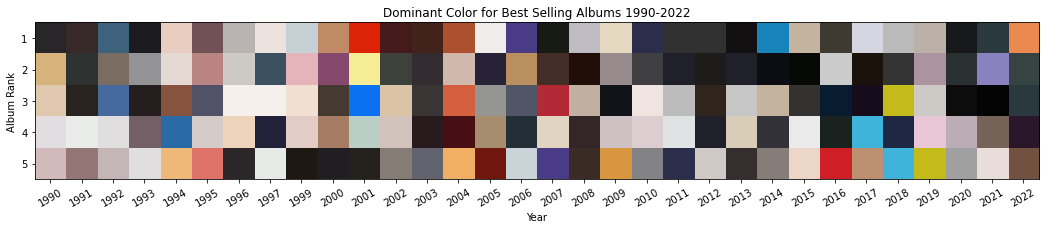

In [45]:
%matplotlib inline

plt.figure(figsize = (18,6))

color_list = list(df_albums.sort_values(by = ['Rank', 'Release Year'])['Color'])

plt.imshow(colors.to_rgba_array(color_list).reshape(5,32,4))
plt.xticks(ticks = range(0,32), labels = list(df_albums['Release Year'].unique()), rotation = 30)
plt.yticks(ticks = range(0,5), labels = [1, 2, 3, 4, 5])
plt.xlabel('Year')
plt.ylabel('Album Rank')
plt.title('Dominant Color for Best Selling Albums 1990-2022')
plt.show()